<a href="https://colab.research.google.com/github/matanlakker/BINA/blob/main/Cnn_Custom_Model_%D7%A1%D7%95%D7%A4%D7%99_%D7%9C%D7%90_%D7%9C%D7%94%D7%A8%D7%99%D7%A5!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#לא להריץ יותר אף פעם!!!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/"

'BINA PROJECT'			       'אפיון בסיסי נתונים אנדו קיור.gdoc'
'Colab Notebooks'		       'בינה מלאכותית הרצאה 3.gdoc'
'DATA SCIENCE PROJECT 1 Ori Mor.gdoc'  'היבטים פסיכולוגיים של מצבי נכות וחולי סיכום.gdoc'
'ERD LORI MED.drawio'		       'היבטים פסיכולוגיים של מצבי נכות וחולי סיכום.pdf'
 ex1DATAbase.drawio		       'היבטים של פסיכולוגיה בחולי ונכות 2 תמלול וסיכום.gdoc'
 hachomer_hatorashti.doc	       'הרצאה 2 פיזיולוגיה תמלול וסיכום.gdoc'
 IMG_4742.jpg			       'מילון מושגים ביוכימיה 1.pdf'
'indian Worker'			       'מילון מושגים כימיה אורגנית ב.pdf'
'LORIMED EX2.drawio'		       'מילון פקודות פייתון.gdoc'
 Notability			       'מילון פקודות פייתון.pdf'
'Notability (1)'		       'מסמך ללא שם.gdoc'
'Notability (2)'		       'סיכום .docx'
'Notability (3)'		       'שנה ב בוקר סמסטר א.gdoc'
'Notability (4)'		       'שנה ב בוקר סמסטר א.pdf'
'Notability (5)'		       'תובנות SweetViz.gdoc'
'Notability (6)'		       'תוכנית פריסה.xlsx'


In [ ]:
!ls "/content/drive/MyDrive/BINA PROJECT/indian Worker/indianWorker"


light  severe  split_data_cnn  split_data_resnet50


In [ ]:
pip install focal-loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
import random
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from focal_loss import BinaryFocalLoss
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau




In [ ]:
# --- הגדרות בסיסיות ---
batch_size = 32
img_size = (224, 224)  # גודל התמונות

# --- נתיבים לתיקיות ---
source_dir_light = "/content/drive/MyDrive/BINA PROJECT/indian Worker/indianWorker/light"
source_dir_severe = "/content/drive/MyDrive/BINA PROJECT/indian Worker/indianWorker/severe"
output_dir = "/content/drive/MyDrive/BINA PROJECT/indian Worker/indianWorker/split_data_cnn"


<div dir="rtl" style="text-align: right; line-height: 1.5;">

חלוקה ל3 סטים שונים: 'train' 0.8 , 'val' 0.1 , 'test' 0.1

In [ ]:
def split_data(source_dir, output_dir, category, test_split=0.1, val_split=0.1):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files if f.endswith(('.png', '.jpg', '.jpeg'))]
    train_files, test_files = train_test_split(files, test_size=test_split, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_split / (1 - test_split), random_state=42)

    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(output_dir, split, category)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            shutil.copy(file, os.path.join(split_dir, os.path.basename(file)))

split_data(source_dir_light, output_dir, "light")
split_data(source_dir_severe, output_dir, "severe")

In [ ]:
# --- אוגמנטציות ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

def preprocess_data(data_dir):
    data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',        #שם הלבייבלים נגזרים משמות התיקיות
        label_mode='binary',      # הגדרת לייבלים כבינארים
        batch_size=batch_size,    # כמות תמונות בבאצ'ים
        image_size=img_size       # שינוי גודל התמונה לגודל אחיד
    )
    data = data.map(lambda x, y: (data_augmentation(x), y))
    data = data.map(lambda x, y: (x / 255.0, y))   #התמונה מנורמלת לערכים בין 0 ל-1
    return data

train_data = preprocess_data(os.path.join(output_dir, "train"))
val_data = preprocess_data(os.path.join(output_dir, "val"))
test_data = preprocess_data(os.path.join(output_dir, "test"))

Found 798 files belonging to 2 classes.
Found 101 files belonging to 2 classes.
Found 101 files belonging to 2 classes.


In [ ]:
# --- בדיקת כמות התמונות בכל סט ---
for category in ['train', 'val', 'test']:
    for subcategory in ['light', 'severe']:
        path = os.path.join(output_dir, category, subcategory)
        print(f"{category}/{subcategory}: {len(os.listdir(path))} images")

train/light: 368 images
train/severe: 430 images
val/light: 47 images
val/severe: 54 images
test/light: 47 images
test/severe: 54 images


In [ ]:
# --- בניית המודל ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  #המודל מקבל תמונות בגודל (224x224x3) המתאימות לתמונות צבעוניות.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)   #מפחית את שיעור הלמידה ב-50% אם פונקציית האובדן על סט האימות אינה משתפרת במשך 2 אפוכים
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- אימון המודל ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    class_weight={0: 1.2, 1: 1.0}
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5242 - loss: 5.9296 - precision: 0.5522 - recall: 0.4582 - val_accuracy: 0.5347 - val_loss: 3.8080 - val_precision: 0.5347 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.5329 - loss: 3.4617 - precision: 0.5458 - recall: 0.7311 - val_accuracy: 0.5248 - val_loss: 2.4179 - val_precision: 0.5319 - val_recall: 0.9259 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.5484 - loss: 2.3003 - precision: 0.5514 - recall: 0.7046 - val_accuracy: 0.5941 - val_loss: 1.8075 - val_precision: 0.5684 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5895 - loss: 1.7852 - precision: 0.5966 - recall: 0.7664 - val_accuracy: 0.6337 - val_loss: 1.5164 - val_precision: 0.5977 - val_recall: 0.9630 - learning_rate: 1.0000e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step -

In [ ]:
# --- הערכת המודל ---
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6433 - loss: 1.0074 - precision: 0.6674 - recall: 0.6804
Test Accuracy: 0.6732673048973083
Test Precision: 0.698113203048706
Test Recall: 0.6851851940155029


In [ ]:
# --- חיזוי וחישוב מטריקות ---
y_true, y_pred = [], []
for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Light", "Severe"]))

conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step

Classification Report:
              precision    recall  f1-score   support

       Light       0.64      0.60      0.62        47
      Severe       0.67      0.70      0.68        54

    accuracy                           0.65       101
   macro avg       0.65      0.65      0.65       101
weighted avg       0.65      0.65      0.65       101


Confusion Matrix:
[[28 19]
 [16 38]]


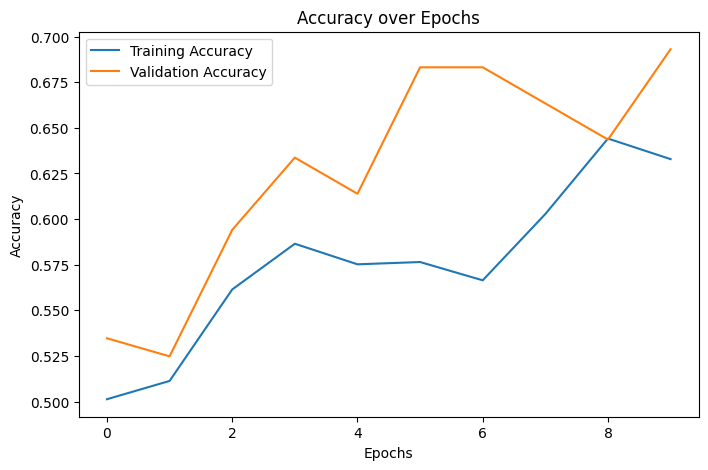

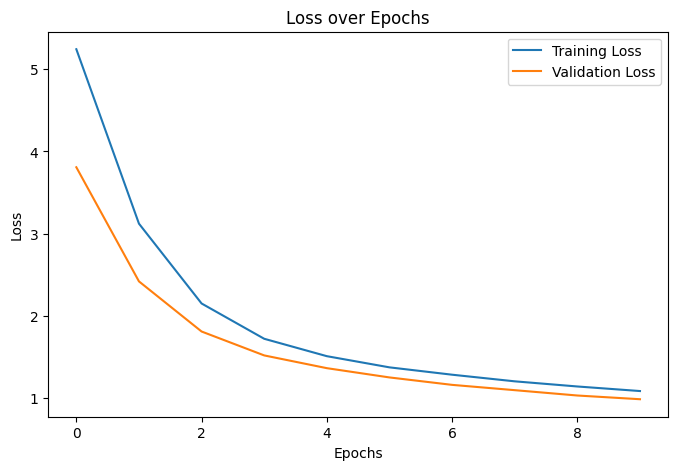

In [ ]:
# --- גרפים ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()